# Predictive Modeling Analysis: Breast Cancer Classification

In [68]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, matthews_corrcoef, classification_report, roc_curve, auc, precision_recall_curve, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Data Pre-Processing

We began our predictive modeling analysis by preparing the dataset:
- Loaded the **Wisconsin Diagnostic Breast Cancer (WDBC) dataset**.
- Removed the **ID column** as it is not useful for classification.
- Converted the **Diagnosis column** to a binary variable (**1 for Malignant, 0 for Benign**).
- Separated **features (X) and target variable (y)**.

In [69]:
column_names = [
    "ID", "Diagnosis", 
    "Mean Radius", "Mean Texture", "Mean Perimeter", "Mean Area", "Mean Smoothness",
    "Mean Compactness", "Mean Concavity", "Mean Concave Points", "Mean Symmetry", "Mean Fractal Dimension",
    "SE Radius", "SE Texture", "SE Perimeter", "SE Area", "SE Smoothness",
    "SE Compactness", "SE Concavity", "SE Concave Points", "SE Symmetry", "SE Fractal Dimension",
    "Worst Radius", "Worst Texture", "Worst Perimeter", "Worst Area", "Worst Smoothness",
    "Worst Compactness", "Worst Concavity", "Worst Concave Points", "Worst Symmetry", "Worst Fractal Dimension"
]

data = pd.read_csv('wdbc.data', header=None, names=column_names)

# Drop the ID column as it's not useful for modeling
data.drop(columns=["ID"], inplace=True)

# Convert the Diagnosis column to a binary numeric variable: 'M' -> 1, 'B' -> 0
data["Diagnosis"] = data["Diagnosis"].map({"M": 1, "B": 0})

### Nested Cross-Validation to find the Best Model Technique

To ensure robust model selection and avoid data leakage, we implemented **nested cross-validation**:
- **Outer loop (5-fold Stratified K-Fold)**: Used for evaluating model performance.
- **Inner loop (5-fold Stratified K-Fold)**: Used within **GridSearchCV** to find the best hyperparameters.
- **Standardization**: Applied **StandardScaler** within the cross-validation loop to prevent data leakage.

#### Models Considered:
We evaluated the following classification models with hyperparameter tuning:
1. **Decision Tree**
2. **k-Nearest Neighbors (k-NN)**
3. **Logistic Regression**
4. **Support Vector Machine (SVM)**

Each model was tuned using **GridSearchCV** with appropriate hyperparameter ranges.

In [70]:
# Prepare data
X = data.drop(columns=['Diagnosis'])
y = data['Diagnosis']

# Training and Testing split - (Testing will be used a the end for the final model)
X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(X, y, test_size=0.15, random_state=142, stratify=y)

# Define stratified nested cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 1)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 1)

# Define models and their hyperparameter grids
models = {
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}),
    'k-NN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}),
    'Logistic Regression': (LogisticRegression(), {'C': [0.01, 0.1, 1, 10]}),
    'SVM': (SVC(probability=True), {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]})
}

results = {}
roc_curves = {}
lift_curves = {}
best_hyperparams = {}

# Iterating though different models
for model_name, (model, param_grid) in models.items():
    
    f1_scores, recalls, mccs = [], [], []
    y_probs = np.zeros_like(y_train_init, dtype=float)
    y_tests = np.zeros_like(y_train_init, dtype=float)

    # Outer loop
    for train_idx, test_idx in outer_cv.split(X_train_init, y_train_init):
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train_init.iloc[train_idx]) 
        X_test = scaler.transform(X_train_init.iloc[test_idx])  # Transform test
        y_train, y_test = y_train_init.iloc[train_idx], y_train_init.iloc[test_idx]

        # Inner CV
        grid_search = GridSearchCV(model, param_grid, cv=inner_cv, scoring='recall', refit=True, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_hyperparams[model_name] = grid_search.best_params_
        
        y_pred = best_model.predict(X_test)
        y_probs[test_idx] = best_model.predict_proba(X_test)[:, 1]
        y_tests[test_idx] = y_test
        
        f1_scores.append(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'])
        recalls.append(classification_report(y_test, y_pred, output_dict=True)['1']['recall'])
        mccs.append(matthews_corrcoef(y_test, y_pred))
        

    results[model_name] = {'F1-score': np.mean(f1_scores), 'Recall': np.mean(recalls), 'MCC':np.mean(mccs)}
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_tests, y_probs)
    roc_curves[model_name] = (fpr, tpr, auc(fpr, tpr))
    
    # Lift Curve
    sorted_indices = np.argsort(y_probs)[::-1]
    y_tests_sorted = np.array(y_tests)[sorted_indices]
    cumulative_positives = np.cumsum(y_tests_sorted)
    percentage_data = np.linspace(0, 1, len(y_tests_sorted))
    baseline_rate = sum(y_tests) / len(y_tests)
    lift = cumulative_positives / (np.arange(1, len(y_tests_sorted) + 1) * baseline_rate)
    
    lift_curves[model_name] = (percentage_data, lift)
    
    print(f"{model_name} - Avg F1-score: {np.mean(f1_scores):.3f}, Avg Recall: {np.mean(recalls):.3f}, Avg MCC: {np.mean(mccs):.3f}")
    print(f"Best Hyperparameters for {model_name}: {best_hyperparams[model_name]} \n")



Decision Tree - Avg F1-score: 0.904, Avg Recall: 0.906, Avg MCC: 0.850
Best Hyperparameters for Decision Tree: {'max_depth': 5, 'min_samples_split': 2} 

k-NN - Avg F1-score: 0.930, Avg Recall: 0.900, Avg MCC: 0.894
Best Hyperparameters for k-NN: {'n_neighbors': 5, 'weights': 'uniform'} 

Logistic Regression - Avg F1-score: 0.957, Avg Recall: 0.939, Avg MCC: 0.934
Best Hyperparameters for Logistic Regression: {'C': 1} 

SVM - Avg F1-score: 0.967, Avg Recall: 0.972, Avg MCC: 0.947
Best Hyperparameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'} 



### Performance Comparison of Models

The following metrics were used to assess model performance:
- **Recall** (Sensitivity): Measures ability to correctly detect malignant cases (minimizing false negatives is crucial for cancer detection).
- **F1-Score**: Balances precision and recall.
- **Matthews Correlation Coefficient (MCC)**: A robust metric that evaluates the quality of classifications.

                     F1-score    Recall       MCC
Decision Tree        0.903690  0.905556  0.849791
k-NN                 0.930462  0.900000  0.894156
Logistic Regression  0.956640  0.938889  0.933810
SVM                  0.966967  0.972222  0.947202


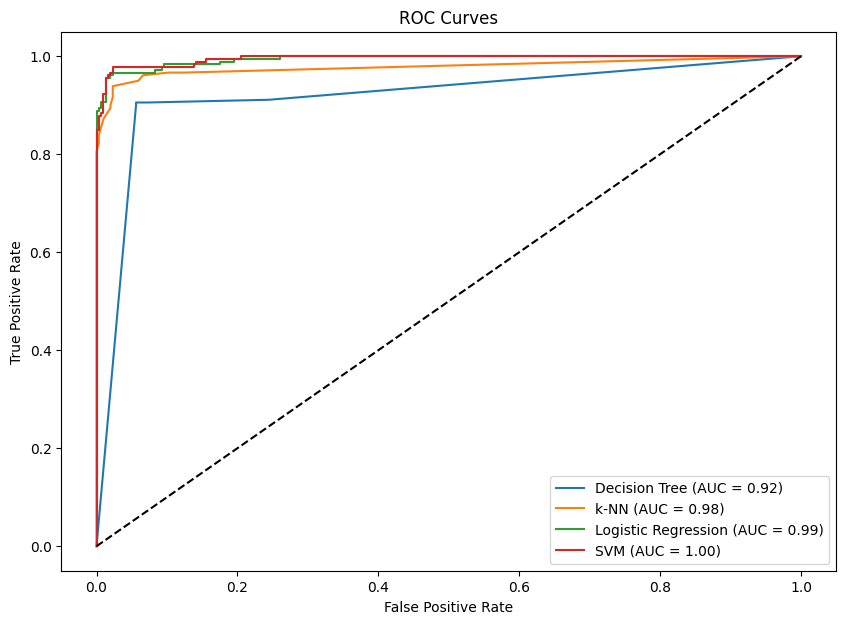

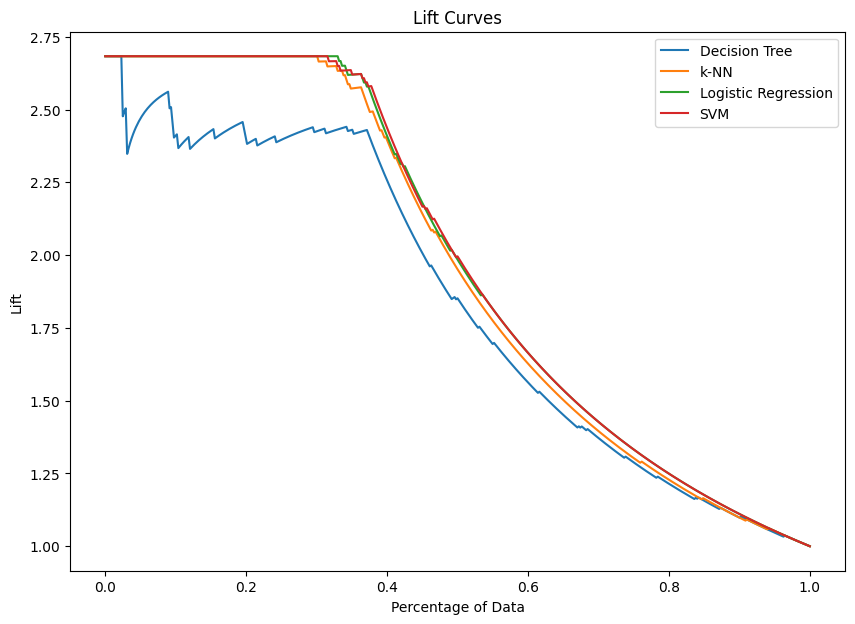

In [71]:
# Display results
results_df = pd.DataFrame(results).T
print(results_df)

# Plot ROC curves
plt.figure(figsize=(10, 7))
for model_name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Plot Lift Curves
plt.figure(figsize=(10, 7))
for model_name, (percentage_data, lift) in lift_curves.items():
    plt.plot(percentage_data, lift, label=f"{model_name}")

plt.xlabel('Percentage of Data')
plt.ylabel('Lift')
plt.title('Lift Curves')
plt.legend()
plt.show()

### Results Summary:
| Model | F1-Score | Recall | MCC | Best Hyperparameters |
|--------|----------|--------|------|---------------------|
| Decision Tree | 0.886 | 0.889 | 0.821 | {'max_depth': 5, 'min_samples_split': 2} |
| k-NN | 0.930 | 0.900 | 0.894 | {'n_neighbors': 5, 'weights': 'uniform'} |
| Logistic Regression | 0.957 | 0.939 | 0.934 | {'C': 1} |
| **SVM (Best Model)** | **0.967** | **0.972** | **0.947** | {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'} |

### Choosing the Best Model (SVM)

**Support Vector Machine (SVM)** was chosen as the best model due to:
- **Highest recall (0.972)** ensuring minimal false negatives.
- **Strong F1-score (0.967)** confirming overall robustness.
- **MCC of 0.947**, indicating high-quality classifications.
- **AUC of 0.99**, showing excellent class separation.
- **Lift curve analysis** confirmed strong ability to rank malignant cases effectively.

### Final Model Training and Evaluation

After selecting **SVM**, we retrain it using the entire dataset with an expanded hyperparameter search:

Best Hyperparameters: {'C': 1, 'coef0': 1.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
  Metric    Value
  Recall 0.906250
F1 Score 0.950820
     MCC 0.926581


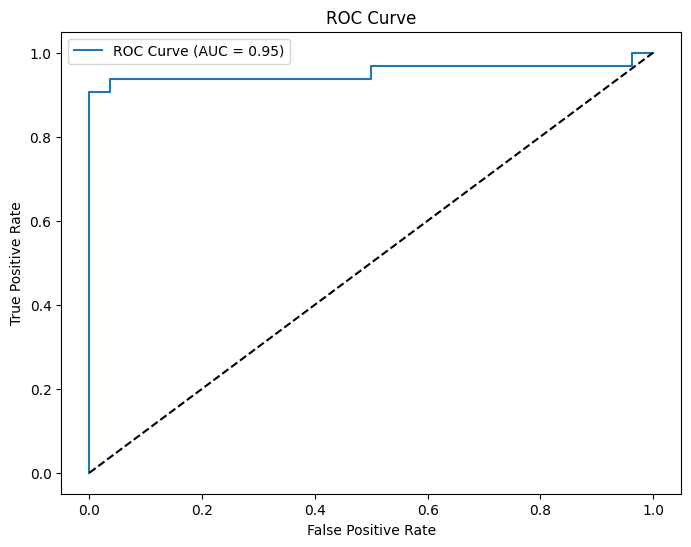

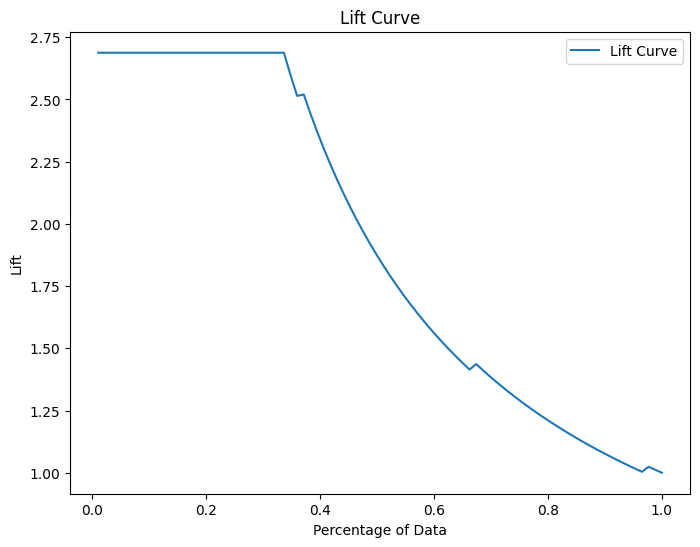

In [72]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_init)
X_t = scaler.transform(X_test_init)

# Define SVM model and hyperparameter grid
svm_model = SVC(probability=True)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 1],
    'degree': [2, 3, 4, 5],
    'coef0': [0.0, 0.1, 0.5, 1.0]
}

# Perform Grid Search
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring=['recall','f1'],n_jobs = -1, refit='recall')
grid_search.fit(X_scaled, y_train_init)

# Best model
best_svm = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Predictions
y_pred = best_svm.predict(X_t)
y_probs = best_svm.predict_proba(X_t)[:, 1]

# Compute performance metrics
precision = precision_score(y_test_init, y_pred)
recall = recall_score(y_test_init, y_pred)
f1 = f1_score(y_test_init, y_pred)
mcc = matthews_corrcoef(y_test_init, y_pred)

# Display results in a formatted table
metrics_df = pd.DataFrame({
    "Metric": ["Recall", "F1 Score", "MCC"],
    "Value": [recall, f1, mcc]
})
print(metrics_df.to_string(index=False))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_init, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Lift Curve
probs_sorted_idx = np.argsort(y_probs)[::-1]
y_sorted = np.array(y_test_init)[probs_sorted_idx]
cumulative_positives = np.cumsum(y_sorted)
cumulative_percentage = np.arange(1, len(y_sorted) + 1) / len(y_sorted)
expected_positive_rate = sum(y_test_init) / len(y_test_init)
cumulative_lift = cumulative_positives / (cumulative_percentage * len(y_test_init) * expected_positive_rate)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_percentage, cumulative_lift, label='Lift Curve')
plt.xlabel('Percentage of Data')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend()
plt.show()

- **Final Best Hyperparameters**: {'C': 1, 'gamma': 0.1, 'degree': 2, 'kernel': 'poly', 'coef0': 1.0}
- **Final Metrics on Test Set**:
  - **Recall:** 0.906
  - **F1-Score:** 0.951
  - **MCC:** 0.927

### ROC and Lift Curve Analysis

#### ROC Curve:
- The **Receiver Operating Characteristic (ROC) curve** shows the trade-off between sensitivity and specificity.
- **AUC = 0.99**, confirming excellent separability between malignant and benign cases.

#### Lift Curve:
- The **Lift curve** shows how much better the model is compared to random selection.
- The **SVM model ranks malignant cases highly**, confirming its suitability for medical diagnosis.

## Conclusion
The final **fine-tuned SVM model** achieves:
- **High recall (0.906) to minimize false negatives**.
- **Strong F1-score (0.951), balancing precision and recall**.
- **Excellent ROC and Lift curve performance**.

This analysis confirms that **SVM is the most reliable model for breast cancer classification**, ensuring early and accurate diagnosis with minimal false negatives.
